## Benchmark loading CELLxGENE Census data in Pytorch

Run this notebook via [Papermill](https://papermill.readthedocs.io/en/latest/) / the [`execute-nb`](https://github.com/ryan-williams/arrayloader-benchmarks/blob/main/execute-nb) wrapper

```bash
./execute-nb us-east-1  # from a g4dn.8xlarge in us-east-1
./execute-nb us-west-2  # from a g4dn.8xlarge in us-west-2
./execute-nb local-nvme -p census_uri '/mnt/nvme/s3/cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma'
./execute-nb subset-nvme -p experiment_uri '/mnt/nvme/census-benchmark_2:7' -p n_vars 0  # 20k vars already sliced
./execute-nb subset-gp3 -p experiment_uri 'data/census-benchmark_2:7' -p n_vars 0  # 20k vars already sliced
```
See [README](https://github.com/ryan-williams/arrayloader-benchmarks?tab=readme-ov-file#census-timing-vs-data-locality) for more info.

**⚠️ This notebook was run with a modified `cellxgene_census` library; see [`main...ryan-williams:cellxgene-census`](https://github.com/chanzuckerberg/cellxgene-census/compare/main...ryan-williams:cellxgene-census:stats?expand=1) ⚠️**

In [1]:
from benchmark import *
from utils import *

from cellxgene_census.experimental.ml import ExperimentDataPipe, experiment_dataloader
from cellxgene_census.experimental.ml.pytorch import pytorch_logger
import torch
from torch.utils.data import DataLoader
torch.ones(2).cuda();

### [Papermill](https://papermill.readthedocs.io/en/latest/) params:

In [2]:
# Set this to read from a local path
experiment_uri = 'data/census-benchmark_2:7'

# None ⟹ fetch from S3
census_uri = None
#census_uri = '/mnt/nvme/s3/cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma'
census_version = "2023-12-15"

# By default:
# - `subset` if `experiment_uri` is a local path
# - `local` if `census_uri` is a local path
# - current (EC2 instance) region if `census_uri` is None (e.g. `us-east-1`, `us-west-2`)
name = 'subset-gp3-dbg'

collection_id = '283d65eb-dd53-496d-adb7-7570c7caa443'
# Slice datasets from `collection_id`
start = 2
end = 7

n_epochs = 1
batch_size = 1024
n_vars = 20_000
soma_chunk_size = 10_000
gc_freq: Optional[int] = None  # When set, run `gc.collect()` every `gc_freq` batches
exclude_first_batch = True
progress_bar = True
torch_log_level = "DEBUG"

# Plot configs
ann_cutoff = .5  # Annotate plot with values for batch timings greater than this threshold
log_plot = False
width = 1200
height = 700

In [3]:
pytorch_logger.setLevel(torch_log_level)

In [4]:
var_query = AxisQuery(coords=(slice(n_vars - 1),)) if n_vars else None

if experiment_uri:
    err(f"Loading experiment {experiment_uri}")
    with profile('open'):
        experiment = Experiment.open(experiment_uri)
    obs_query = None
    if name is None:
        scheme = urlparse(experiment_uri).scheme
        if is_local(experiment_uri):
            name = 'subset'
else:
    if not census_uri:
        census_uri = None
    
    if name is None:
        if census_uri and is_local(census_uri):
            name = 'local'
        else:
            name = get_region()
    
    err(f"Loading census ({name})")

    with profile('open_soma'):
        census = cellxgene_census.open_soma(uri=census_uri, census_version=census_version)
    
    datasets = get_datasets(census, collection_id, 'datasets')
    err(f"{len(datasets)} datasets: {datasets[:10]}")
    
    experiment = census["census_data"]["homo_sapiens"]
    ds = datasets[slice(start, end)]
    datasets_query = "dataset_id in " + str(ds)
    obs_query = AxisQuery(value_filter=datasets_query)

if not name:
    raise ValueError("`name` not set")

experiment

Loading experiment data/census-benchmark_2:7


<Experiment 'data/census-benchmark_2:7' (open for 'r') (2 items)
    'obs': 'file:///home/ec2-user/c/tiledb/arrayloader-benchmarks/data/census-benchmark_2:7/obs' (unopened)
    'ms': 'file:///home/ec2-user/c/tiledb/arrayloader-benchmarks/data/census-benchmark_2:7/ms' (unopened)>

In [5]:
%%time
with profile('get_exp_datapipe'):
    experiment_datapipe = ExperimentDataPipe(
        experiment,
        measurement_name="RNA",
        X_name="raw",
        obs_query=obs_query,
        var_query=var_query,
        batch_size=batch_size,
        shuffle=True,
        soma_chunk_size=soma_chunk_size,
    )
    loader = experiment_dataloader(experiment_datapipe)
exp = Exp(experiment_datapipe, loader)
exp

CPU times: user 4.43 ms, sys: 140 µs, total: 4.57 ms
Wall time: 4.09 ms


Exp(datapipe=ExperimentDataPipe, loader=<torch.utils.data.dataloader.DataLoader object at 0x7fcfb7507950>)

In [6]:
%%time
print(f"Data shape: {exp.datapipe.shape}, pid {os.getpid()}")

Initializing ExperimentDataPipe
Initializing encoders


Data shape: (133790, 20000), pid 20277
CPU times: user 94.1 ms, sys: 86.7 ms, total: 181 ms
Wall time: 67.1 ms


## Run benchmark

In [7]:
%%time
epochs = []
for epoch in range(n_epochs):
    with profile(f'benchmark-epoch{epoch}'):
        epoch = benchmark(
            exp,
            batch_size=batch_size,
            gc_freq=gc_freq,
            exclude_first_batch=exclude_first_batch,
            progress_bar=progress_bar,
        )
    epochs.append(epoch)

results = Results(
    census=Method('census', epochs),
)

Using self.soma_chunk_size=10000
Shuffling 133790 obs joinids into 14 chunks of 10000
Process 20277 handling partition 1 of 1, partition_size=133790
Retrieving next SOMA chunk...
gc:  pre=(pfullmem(rss=1912160256, vms=28006039552, shared=546230272, text=3342336, lib=0, data=10945335296, dirty=0, uss=1895727104, pss=1903364096, swap=0), svmem(total=133636747264, available=127051792384, percent=4.9, used=5350592512, free=123457486848, active=7324889088, inactive=1747468288, buffers=2138112, cached=4826529792, shared=13348864, slab=422486016), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))
gc: post=(pfullmem(rss=1914953728, vms=27376644096, shared=547614720, text=3342336, lib=0, data=10336571392, dirty=0, uss=1899220992, pss=1906857984, swap=0), svmem(total=133636747264, available=127059439616, percent=4.9, used=5342945280, free=123465125888, active=7326846976, inactive=1747476480, buffers=2138112, cached=4826537984, shared=13348864, slab=414380032), sswap(total=0, used=0, fr

time per sample: 333.55 μs
samples per sec: 2998.02 samples/sec
CPU times: user 1min 13s, sys: 37.3 s, total: 1min 51s
Wall time: 49 s


In [8]:
exp_stats = experiment_datapipe.stats()
exp_stats

Stats(n_obs=133790, nnz=370587587, elapsed=47.380566120147705, n_soma_chunks=14, checkpoints=[{'obs_joinids_chunk': 0.0002727508544921875, 'obs_batch': 0.17963719367980957, 'obs_batch_reindex': 0.0015857219696044922, 'scipy_iter': 0.0061457157135009766, 'X_batch': 3.9312191009521484}, {'obs_joinids_chunk': 0.00018024444580078125, 'obs_batch': 0.056635379791259766, 'obs_batch_reindex': 0.0006821155548095703, 'scipy_iter': 0.008401632308959961, 'X_batch': 3.6689293384552}, {'obs_joinids_chunk': 0.00041174888610839844, 'obs_batch': 0.02953052520751953, 'obs_batch_reindex': 0.0007176399230957031, 'scipy_iter': 0.0067827701568603516, 'X_batch': 2.465601682662964}, {'obs_joinids_chunk': 0.00029659271240234375, 'obs_batch': 0.036464691162109375, 'obs_batch_reindex': 0.0008494853973388672, 'scipy_iter': 0.00953364372253418, 'X_batch': 4.215155363082886}, {'obs_joinids_chunk': 0.000751495361328125, 'obs_batch': 0.03069901466369629, 'obs_batch_reindex': 0.0009477138519287109, 'scipy_iter': 0.009

In [9]:
tdb.stats

{'open': [{'timers': {'Context.StorageManager.sm_load_group_metadata.sum': 7.086e-05,
    'Context.StorageManager.sm_load_group_metadata.avg': 7.086e-05,
    'Context.StorageManager.sm_load_group_from_uri.sum': 9.7561e-05,
    'Context.StorageManager.sm_load_group_from_uri.avg': 9.7561e-05,
    'Context.StorageManager.sm_load_group_details.sum': 0.000102126,
    'Context.StorageManager.sm_load_group_details.avg': 0.000102126,
    'Context.StorageManager.group_open_for_reads.sum': 0.000104562,
    'Context.StorageManager.group_open_for_reads.avg': 0.000104562},
   'counters': {'Context.StorageManager.read_unfiltered_byte_num': 262,
    'Context.StorageManager.read_group_size': 70,
    'Context.StorageManager.read_array_meta_size': 192,
    'Context.StorageManager.VFS.read_ops_num': 6,
    'Context.StorageManager.VFS.read_byte_num': 333,
    'Context.StorageManager.VFS.ls_num': 3}}],
 'get_exp_datapipe': [],
 'benchmark-epoch0': []}

In [10]:
tdbs.stats

{'open': [], 'get_exp_datapipe': [], 'benchmark-epoch0': []}

In [11]:
checkpoints_df = exp_stats.checkpoints_df()
checkpoints_df

,obs_joinids_chunk,obs_batch,obs_batch_reindex,scipy_iter,X_batch
0,0.000273,0.179637,0.001586,0.006146,3.931219
1,0.000180,0.056635,0.000682,0.008402,3.668929
2,0.000412,0.029531,0.000718,0.006783,2.465602
3,0.000297,0.036465,0.000849,0.009534,4.215155
4,0.000751,0.030699,0.000948,0.009613,3.298066
5,0.000488,0.027671,0.000592,0.007083,3.405928
6,0.000440,0.032814,0.001234,0.011159,4.409173
7,0.000234,0.033957,0.000885,0.009506,3.077499
8,0.000214,0.027428,0.000683,0.007379,4.232040
9,0.000383,0.075540,0.000805,0.010984,2.387380


In [12]:
checkpoints_df.sum()

obs_joinids_chunk     0.006066
obs_batch             0.667487
obs_batch_reindex     0.013664
scipy_iter            0.124903
X_batch              46.567994
dtype: float64

In [13]:
results_json_path = f'results/{name}.json'
with open(results_json_path, 'w') as f:
    json.dump(asdict(results), f, indent=2)
    err(f"Saved results to {results_json_path}")

Saved results to results/subset-gp3-dbg.json


In [14]:
# with open(results_json_path, 'r') as f:
#     results = Results(**json.load(f))

## Plot batch timings

In [15]:
method = 'census'
epoch = 0
batches = getattr(results, 'census').epochs[epoch].batches
df = pd.DataFrame(batches)
df['gc'] = df['gc'].fillna(nan)
if df.gc.isna().all():
    df = df.drop(columns='gc')
df.index.name = 'idx'
df = df.reset_index()
df

/tmp/ipykernel_20277/2254310219.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gc'] = df['gc'].fillna(nan)


,idx,batch
0,0,0.266165
1,1,0.183117
2,2,0.187992
3,3,0.183158
4,4,0.238058
...,...,...
125,125,0.095986
126,126,0.101035
127,127,0.100886
128,128,0.101868


In [16]:
ann = df[df.batch > ann_cutoff] if ann_cutoff else df[[]]
ann

,idx,batch
8,8,2.162117
17,17,1.109661
26,26,2.909929
36,36,1.862071
45,45,2.034531
54,54,3.037621
64,64,1.592906
73,73,2.957584
82,82,0.980328
92,92,1.822545


In [17]:
pc

PlotConfigs(fmt='fig', w=1200, h=800, save=[], v=True, i=None, dir=None, grid='#ccc', bg='white')

Saving: img/census-subset-gp3-dbg.png
Returning IPython Image


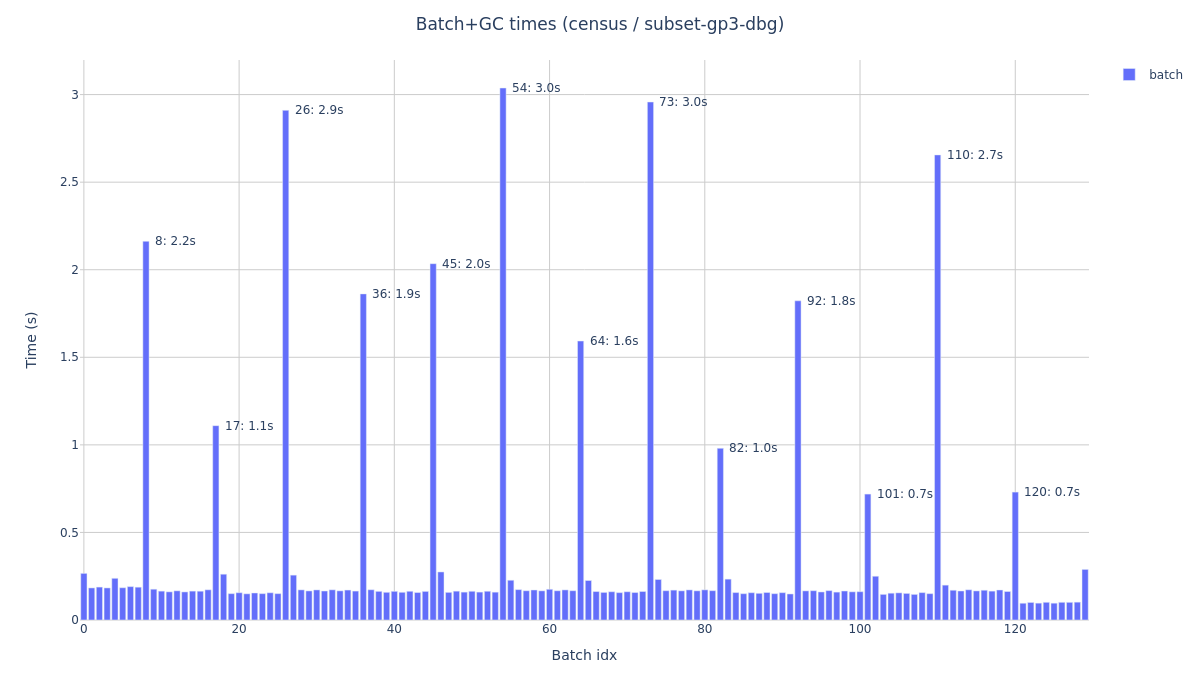

In [18]:
fig = px.bar(
    df.set_index('idx')[['batch', *(['gc'] if 'gc' in df else [])]],
    barmode='stack',
    labels={
        'idx': 'Batch idx',
        'variable': '',
        'value': 'Time (s)',
    },
    log_y=log_plot,
).update_layout(
    title=dict(text=f'Batch+GC times ({method} / {name})'),
).update_xaxes(
    range=(-.5, len(df) - 1 + .5),
)

if not ann.empty:
    anns = ann.set_index('idx').batch.to_dict().items()
    for idx, batch in anns:
        fig.add_annotation(
            x=idx, y=log10(batch) if log_plot else batch,
            showarrow=False,
            text=f'{idx}: {batch:.1f}s',
            xshift=7,
            xanchor='left',
        )

plot(fig, f'census-{name}', fmt='png', save=['png'], w=width, h=height, dir='img',)